# Load Packages

In [1]:
using Dates, DelimitedFiles, JuMP, Ipopt

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printTable2

In [2]:
using Plots

#pyplot(size=(600,400))           #pyplot or gr
gr(size=(480,320))
default(fmt = :svg)    

# Loading Data

In [3]:
(x,header) = readdlm("Data/Fin1PerfEvalEmp.csv",',',header=true)

(IndNames,FundNames) = (header[2:9],header[10:11])     #names of variables

dN          = Date.(x[:,1],"yyyy-mm-dd")    #convert to Date
(Rb,RFunds) = (convert.(Float64,x[:,2:9]),convert.(Float64,x[:,10:11]))  #convert to get Float64

println()

# A Function for Style Analysis


Notice:  
(a)  The regression is $Y = b_1 X_1 + ...+ b_K X_K + u$,
               where $0 <= b_j$ and $\sum_{i=1}^{K}b_i = 1$. 
               
(b) Write the sum of squared residuals of the regression as   

$(Y-Xb)'(Y-Xb) = Y'Y - 2Y'Xb + b'X'Xb$. 

Only the two last terms matter for the choice of $b$. 
                             
(c) To minimize $- 2Y'Xb + b'X'Xb$, we use the JuMP package. 

In [4]:
function StyleAnalysisPs(Y,X)

    (T,K) = (size(X,1),size(X,2))
    Q = X'X/T                           #calculate Q and c once. 1/T may help precision       
    c = Y'X/T    

    b_ls = X\Y                          #LS estimate of weights, no restrictions
 
    model = Model(with_optimizer(Ipopt.Optimizer, print_level = 1))
    @variable(model,b[i=1:K] >= 0.0)       #no short sales
    @objective(model,Min,-2*c*b + b'*Q*b)  #to minimize
    @constraint(model,sum(b) == 1.0)       #sums to 1
    optimize!(model)
    if has_values(model)
        b_sa = value.(b)
    else
        b_sa = NaN
    end
 
    return b_sa,b_ls

end

StyleAnalysisPs (generic function with 1 method)

The next cell makes a "style analysis regression" based on the entire sample. The dependent variable is the first mutual fund in RFunds (see data loading) and all indices (again, see data loading) are used as regressors.

In [5]:
(b,b_ls) = StyleAnalysisPs(RFunds[:,1],Rb)

println("OLS and style analysis coeffs")
colNames = ["OLS" "Restricted LS"]
xut      = [b_ls b;sum([b_ls b],dims=1)]
printTable(xut,colNames,[IndNames;"Sum"],width=15)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

OLS and style analysis coeffs
                                      OLS  Restricted LS
S&P 500                             0.429          0.429
S&P MidCap 400                      0.086          0.087
S&P Small Cap 600                   0.067          0.069
World Developed - Ex. U.S.          0.199          0.203
Emerging Markets                    0.054          0.059
US Corporate Bonds                  0.176          0.070
U.S. Treasury Bills                 0.085          0.083
US Treasury                        -0.151          0.001
Sum                                 0.944          1.000



# Redo the Style Analysis on a Moving Data Window 

of size `WinSize` (see below). Then plot to see how the coefficients change over time. 

In [6]:
(T,K)   = size(Rb)
WinSize = 104

b = fill(NaN,(T,K))
for t = (WinSize+1):T
    local vv
    vv     = (t-WinSize):t
    b[t,:] = StyleAnalysisPs(RFunds[vv,1],Rb[vv,:])[1]
end

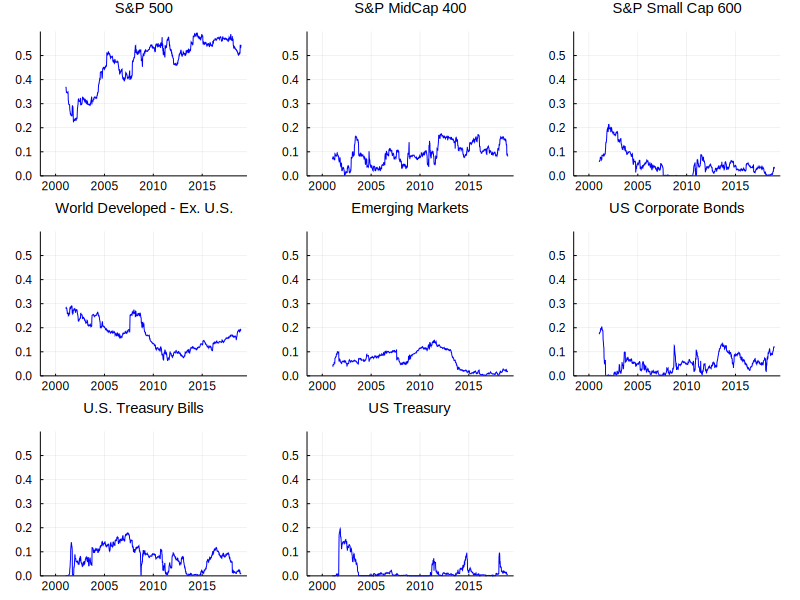

In [7]:
xTicksLoc = Dates.value.([Date(2000);Date(2005);Date(2010);Date(2015)])
xTicksLab = ["2000";"2005";"2010";"2015"]

p1 = plot(dN,b,layout=(3,3),legend=false,size=(800,600),
          color=:blue,xticks=(xTicksLoc,xTicksLab),ylims=(0,0.6),
          title=[permutedims(IndNames) ""],titlefont=font(10))

#modify subplot [3,3] to be blank
plot!(p1[3,3],legend=false,grid=false,foreground_color_subplot=:white)      